# Kickstarter Projects Python Code

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from scipy.stats import uniform as sp_rand
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# for figures to show up in the notebook:
init_notebook_mode(connected=True) 

In [3]:
np.random.seed(101)

In [4]:
# Set plotting styles
sns.set_style('white')  

In [5]:
# Machine learning libraries:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/langwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import warnings 
warnings.simplefilter('ignore')

----
## Get the data

In [7]:
df = pd.read_csv('ks-projects-201801.csv', encoding='ISO-8859-1')

In [8]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


----
## Data Cleaning

In [10]:
# Drop duplicate data
df = df.drop_duplicates()

In [11]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [12]:
# Subset the df with all the columns I want.
df = df[['name', 'category', 'main_category', 'launched', 'deadline', 'currency', 
         'usd_goal_real', 'usd_pledged_real', 'backers', 'state']]

In [13]:
# Where are all the NaN values for each column?
df.isnull().sum()

name                4
category            0
main_category       0
launched            0
deadline            0
currency            0
usd_goal_real       0
usd_pledged_real    0
backers             0
state               0
dtype: int64

In [14]:
# Drop the 4 rows that have NaN value in the 'name' column.
df.dropna(inplace=True)

In [15]:
# Rename some columns
df.rename(columns={'usd_goal_real':'goal', 'usd_pledged_real':'pledged'}, inplace=True) 

In [16]:
df.head(2)

,name,category,main_category,launched,deadline,currency,goal,pledged,backers,state
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-08-11 12:12:28,2015-10-09,GBP,1533.95,0.0,0,failed
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-09-02 04:43:57,2017-11-01,USD,30000.00,2421.0,15,failed


In [17]:
# df['state'] is the target column. 
df['state'].value_counts()

failed        197716
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1845
Name: state, dtype: int64

In [18]:
# Only keep rows of the df that are either 'failed' or 'successful' in the 'state' column.
df = df[(df['state']=='failed') | (df['state']=='successful')]

In [19]:
df['state'].value_counts()

failed        197716
successful    133956
Name: state, dtype: int64

In [20]:
# Change 'launched' column into a DateTime object
df['launched'] =  pd.to_datetime(df['launched'], format='%Y-%m-%d %H:%M:%S')

In [21]:
# Do a feature engineering on the DateTime column to return date only
def feature_1(col):
    date_time = col[0]
    return date_time.date()

In [22]:
# Apply to the 'launched' column
df['launched'] = df[['launched']].apply(feature_1, axis=1)

In [23]:
# Check
type(df['launched'][0])

datetime.date

In [24]:
# Do the same thing with the 'deadline' column
df['deadline'] =  pd.to_datetime(df['deadline'])

In [25]:
df['deadline'] = df[['deadline']].apply(feature_1, axis=1)

In [26]:
# type(df['deadline'][0])

In [27]:
# Compute new column 'days'
df['days'] = df['deadline'] - df['launched']

In [28]:
# Do a feature engineering on the DateTime column to return number of days only.
def feature_2(col):
    date_time = col[0]
    return date_time.days

In [29]:
df['days'] = df[['days']].apply(feature_2, axis=1)

In [30]:
# df['days']

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 11 columns):
name             331672 non-null object
category         331672 non-null object
main_category    331672 non-null object
launched         331672 non-null object
deadline         331672 non-null object
currency         331672 non-null object
goal             331672 non-null float64
pledged          331672 non-null float64
backers          331672 non-null int64
state            331672 non-null object
days             331672 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 40.4+ MB


In [32]:
df.head()

,name,category,main_category,launched,deadline,currency,goal,pledged,backers,state,days
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-08-11,2015-10-09,GBP,1533.95,0.0,0,failed,59
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-09-02,2017-11-01,USD,30000.00,2421.0,15,failed,60
2,Where is Hank?,Narrative Film,Film & Video,2013-01-12,2013-02-26,USD,45000.00,220.0,3,failed,45
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-03-17,2012-04-16,USD,5000.00,1.0,1,failed,30
5,Monarch Espresso Bar,Restaurants,Food,2016-02-26,2016-04-01,USD,50000.00,52375.0,224,successful,35


----
## Outliers

In [33]:
round(df.describe(), 1)

,goal,pledged,backers,days
count,331672.0,331672.0,331672.0,331672.0
mean,41509.7,9943.5,116.4,34.0
std,1108934.6,96733.4,965.4,12.7
min,0.0,0.0,0.0,1.0
25%,2000.0,50.0,2.0,30.0
50%,5000.0,788.0,15.0,30.0
75%,15000.0,4608.0,63.0,36.0
max,166361390.7,20338986.3,219382.0,92.0


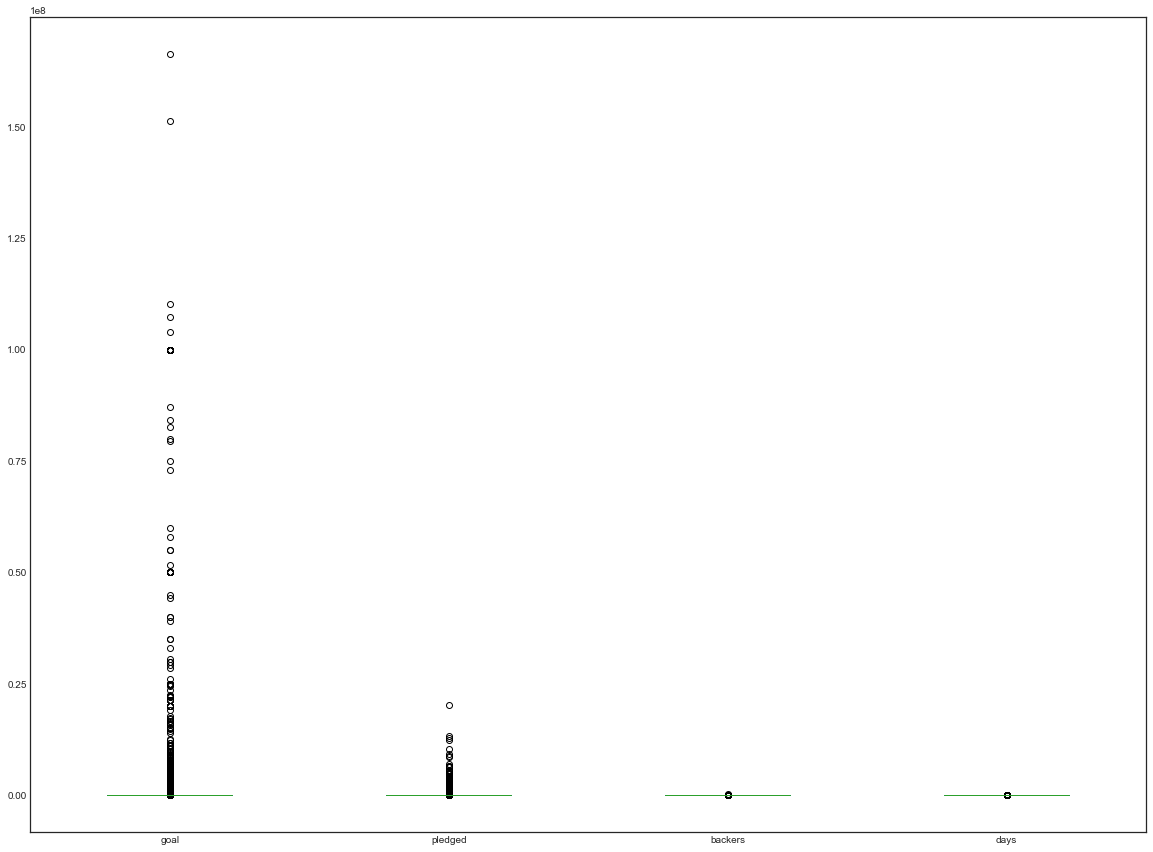

In [34]:
df.plot.box(figsize=(20,15))
 

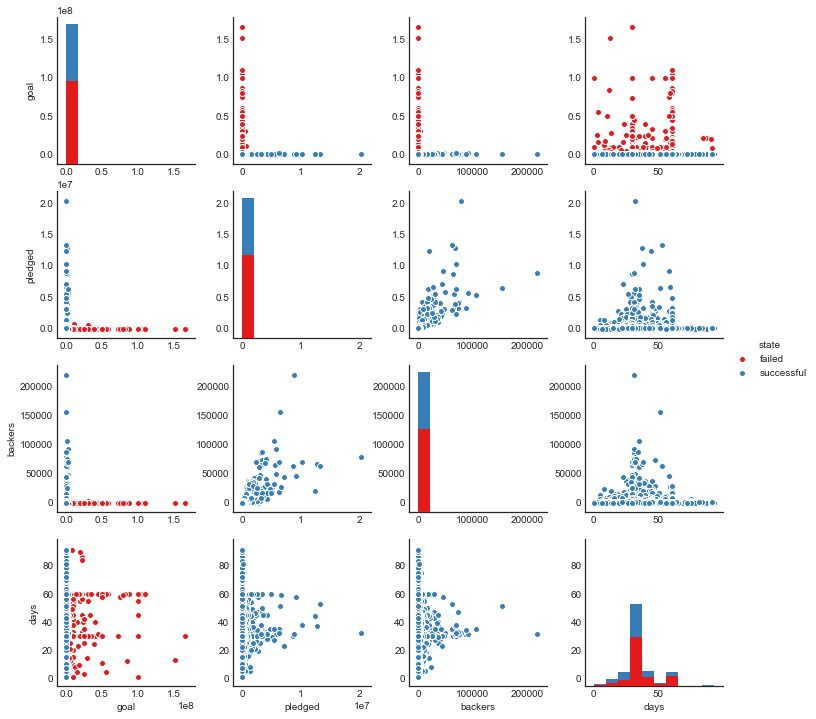

In [35]:
# Do a pairplot on the numeric columns of the data frame
sns.pairplot(df, hue='state', palette='Set1')


In [36]:
# We can see from the pairplot that columns 'goal', 'pledged' and 'backers' are heavily-skewed.

In [37]:
# Make a function to detect outliers with IQR constant being 1000.
def remove_outliers(x, outlier_constant=1000):
    
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    iqr = (upper_quartile - lower_quartile) * outlier_constant
    quartile_set = (lower_quartile - iqr, upper_quartile + iqr)
    outlier_list = []
    
    for y in a.tolist():
        if y < quartile_set[0] or y > quartile_set[1]:
            outlier_list.append(y)
    print(quartile_set)
    print('')
    print(outlier_list)
    return quartile_set

In [38]:
# Check outliers for the 'goal' column
goal_set = remove_outliers(df.goal)

(-12998000.0, 13015000.0)

[17104542.97, 33000000.0, 100000000.0, 100000000.0, 50000000.0, 73000000.0, 20000000.0, 51647023.58, 166361390.71, 100000000.0, 15000000.0, 21474836.0, 22000000.0, 84300785.2, 100000000.0, 100000000.0, 100000000.0, 50000000.0, 50000000.0, 15000000.0, 87092840.97, 16250000.0, 20000000.0, 55000000.0, 40000000.0, 29242486.89, 44336067.39, 79478620.25, 16000000.0, 21474836.47, 100000000.0, 100000000.0, 25000000.0, 45000000.0, 50000000.0, 14787430.68, 60000000.0, 21474836.0, 35000000.0, 22250000.0, 58000000.0, 151395869.92, 30000000.0, 26000000.0, 20000000.0, 50000000.0, 22327409.13, 75000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 40000000.0, 107369867.72, 104057189.83, 50000000.0, 15000000.0, 30488734.41, 55000000.0, 82624142.77, 16610000.0, 23564157.35, 35000000.0, 28530019.29, 100000000.0, 100000000.0, 16610000.0, 25000000.0, 25000000.0, 22500000.0, 22000000.0, 14332191.54, 21474836.0, 80000000.0, 100000000.0, 20000000.0, 21474836.47, 19136558.4

In [39]:
# Check outliers for the 'pledged' column
pledged_set = remove_outliers(df.pledged)

(-4557950.0, 4562608.0)

[5020667.05, 8596474.58, 5545991.7, 6225354.98, 6465690.3, 5764229.38, 5333792.84, 5702153.38, 20338986.27, 5004494.58, 8782571.99, 12779843.49, 13285226.36, 6565782.5, 10266845.74, 12393139.69, 4729263.13, 5408916.95, 9192055.66, 5494492.81, 7072757.0, 4869472.2, 6333295.77]


In [40]:
# Check outliers for the 'backers' column
backers_set = remove_outliers(df.backers)

(-60998.0, 61063.0)

[63416, 64867, 85581, 73206, 154926, 63758, 91585, 78471, 87142, 219382, 61290, 70122, 66673, 74405, 62642, 73986, 68929, 105857, 67226, 69320]


In [41]:
# Check outliers for the 'day' column
days_set = remove_outliers(df.days)

(-5970.0, 6036.0)

[]


In [42]:
# Make a data frame 'df_clean', which is a data frame without all the outliers.
df_clean = df[(df.goal >= goal_set[0]) & (df.goal <= goal_set[1]) & 
              (df.pledged >= pledged_set[0]) & (df.pledged <= pledged_set[1]) &  
              (df.backers >= backers_set[0]) & (df.backers <= backers_set[1]) &  
              (df.days >= days_set[0]) & (df.days <= days_set[1])]


In [43]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331539 entries, 0 to 378660
Data columns (total 11 columns):
name             331539 non-null object
category         331539 non-null object
main_category    331539 non-null object
launched         331539 non-null object
deadline         331539 non-null object
currency         331539 non-null object
goal             331539 non-null float64
pledged          331539 non-null float64
backers          331539 non-null int64
state            331539 non-null object
days             331539 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 30.4+ MB


In [44]:
df_clean.describe()

,goal,pledged,backers,days
count,3.315390e+05,3.315390e+05,331539.000000,331539.000000
mean,2.582752e+04,9.307424e+03,110.242309,33.951402
std,1.974988e+05,6.164082e+04,615.786989,12.709863
min,1.000000e-02,0.000000e+00,0.000000,1.000000
25%,2.000000e+03,5.000000e+01,2.000000,30.000000
50%,5.000000e+03,7.890000e+02,15.000000,30.000000
75%,1.500000e+04,4.607000e+03,63.000000,36.000000
max,1.264302e+07,4.236618e+06,46520.000000,92.000000


In [45]:
# Since columns 'goal', 'pledged' and 'backers' are heavily-skewed, I decide to include the outliers 
# in my following data exploration and analysis.

----
## Exploratory Data Analysis

#### Step 1: Overall Data Visualization

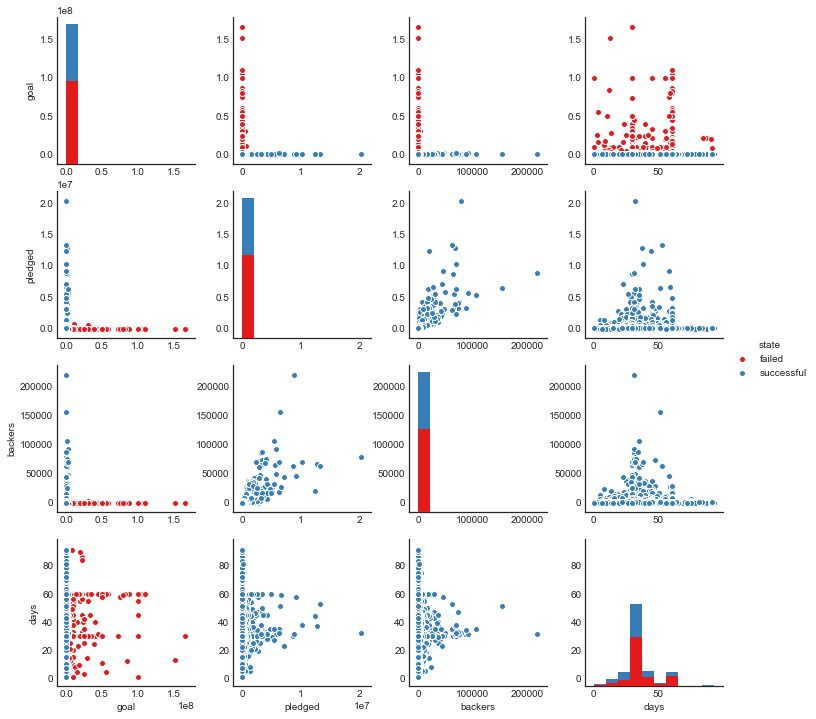

In [46]:
sns.pairplot(df, hue='state', palette='Set1')


In [47]:
# Some comments about the pairplot.
# heavily-skewed data for columns 'goal', 'pledged', 'backers'. 
# So when I do exploratory analysis on these columns, best to use median instead of mean.

In [48]:
# Make a correlation heatmap
df_drop = df.drop('state', axis = 1) 
df_corr = df_drop.corr()
df_corr

,goal,pledged,backers,days
goal,1.000000,0.006354,0.005208,0.021606
pledged,0.006354,1.000000,0.752291,0.008652
backers,0.005208,0.752291,1.000000,-0.000049
days,0.021606,0.008652,-0.000049,1.000000


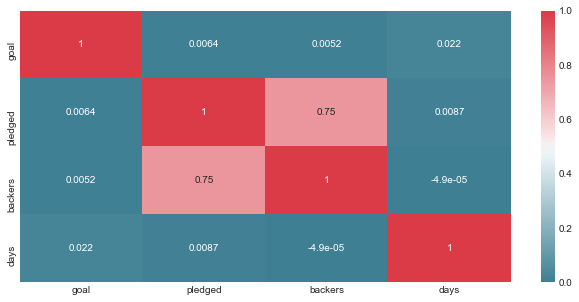

In [49]:
# Set up the matplotlib figure:
f, ax = plt.subplots(figsize=(11, 5))

# Generate a custom diverging colormap:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, annot=True, cmap=cmap, xticklabels=df_corr.columns, yticklabels=df_corr.columns)


In [50]:
# Some comments about the heatmap:
# Columns 'pledged' and 'backers' have a strong positive correlation, which is not surprising.
# Pairings such as 'goal' and 'pledged', 'goal' and 'backers' have approximately zero correlation.
# column 'days' have approximately zero correlation with columns 'goal' and 'pledged', 
# but a negative correlation with column 'backers'.

----
#### Step 2: Failed v.s Successful Visualizations

Text(0.5,1,'Failed vs. Successful Kickstarter Projects')

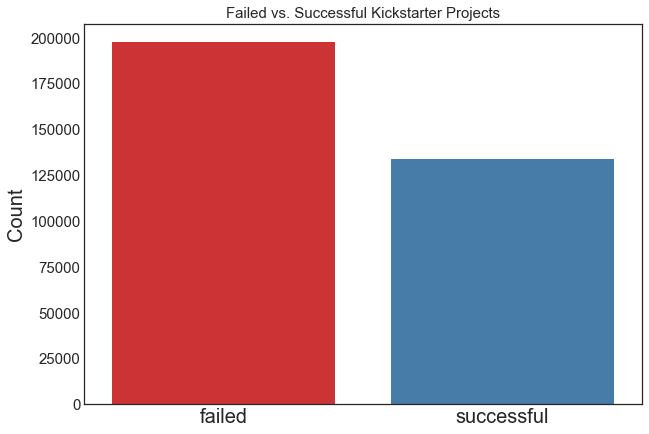

In [51]:
# Number of Failed vs. Successful Kickstarter Projects
plt.figure(figsize=(10,7))
sns.countplot(df['state'], palette='Set1')
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Count', fontsize=20)
plt.title('Failed vs. Successful Kickstarter Projects', fontsize=15)

Text(0.5,1,'Failed vs. Successful Kickstarter Projects by Currency')

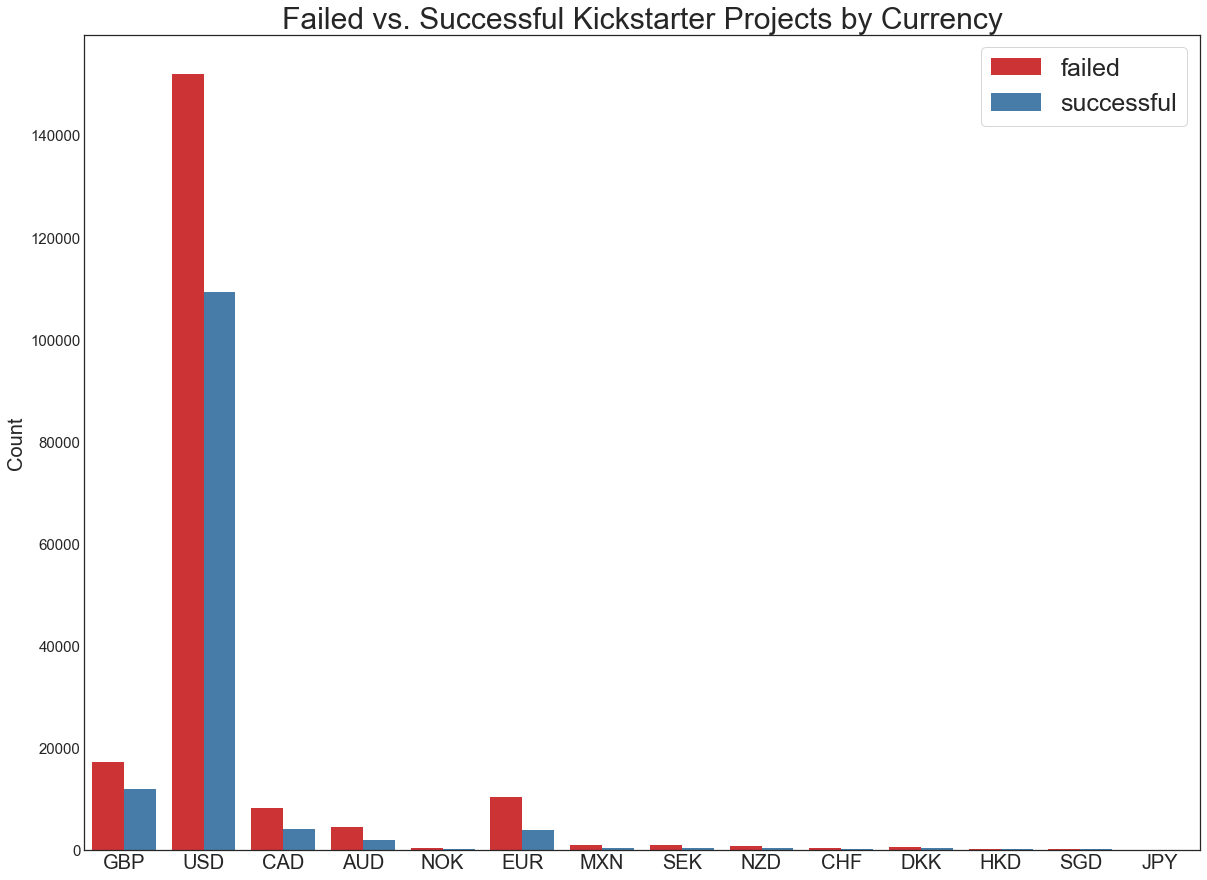

In [52]:
# Number of Failed and Successful Kickstarter Projects by Currency
plt.figure(figsize=(20,15))
sns.countplot('currency', hue='state', dodge=True, data=df, palette='Set1')
plt.legend(loc='best', frameon=True, fontsize=25)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Count', fontsize=20)
plt.title('Failed vs. Successful Kickstarter Projects by Currency', fontsize=30)


In [53]:
df_state_median = df.groupby('state')[['goal', 'pledged', 'backers', 'days']].median().reset_index()
df_state_median

,state,goal,pledged,backers,days
0,failed,7500.00,100.00,3,30
1,successful,3837.74,5107.25,71,30


Text(0.5,1,'Failed vs. Successful Kickstarter Projects by Median Goal and Pledged Amounts')

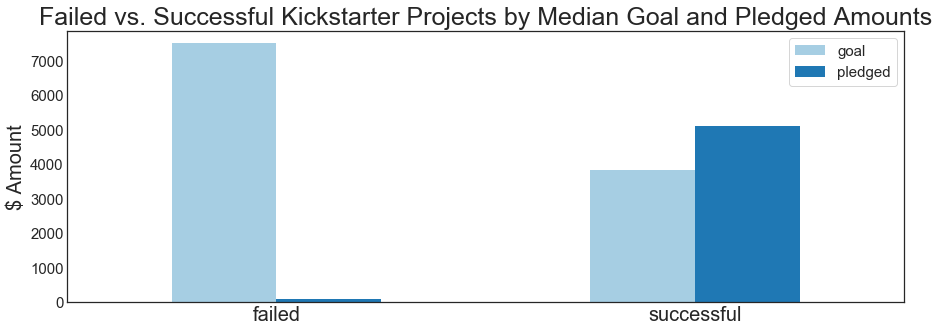

In [54]:
# Failed vs. Successful Kickstarter Projects by Median Goal and Pledged Amounts
df_state_median.plot.bar(x='state', y=['goal', 'pledged'], stacked=False, figsize=(15,5), 
                         color=sns.color_palette('Paired'))
plt.legend(loc='best', frameon=True, fontsize=15)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('$ Amount', fontsize=20)
plt.title('Failed vs. Successful Kickstarter Projects by Median Goal and Pledged Amounts', fontsize=25)


Text(0.5,1,'Failed vs. Successful Kickstarter Projects by Median Number of Backers')

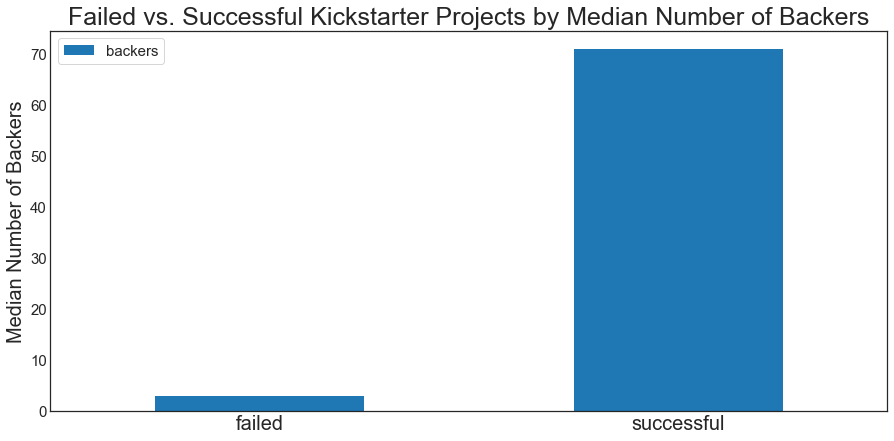

In [55]:
# Failed vs. Successful Kickstarter Projects by Median Number of Backers
df_state_median.plot.bar(x='state', y='backers', stacked=True, figsize=(15,7))
plt.legend(loc='best', frameon=True, fontsize=15)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Median Number of Backers', fontsize=20)
plt.title('Failed vs. Successful Kickstarter Projects by Median Number of Backers', fontsize=25)


----
#### Step 3: Visualizations by Categories

Text(0.5,1,'Failed vs. Successful Kickstarter Projects by Category')

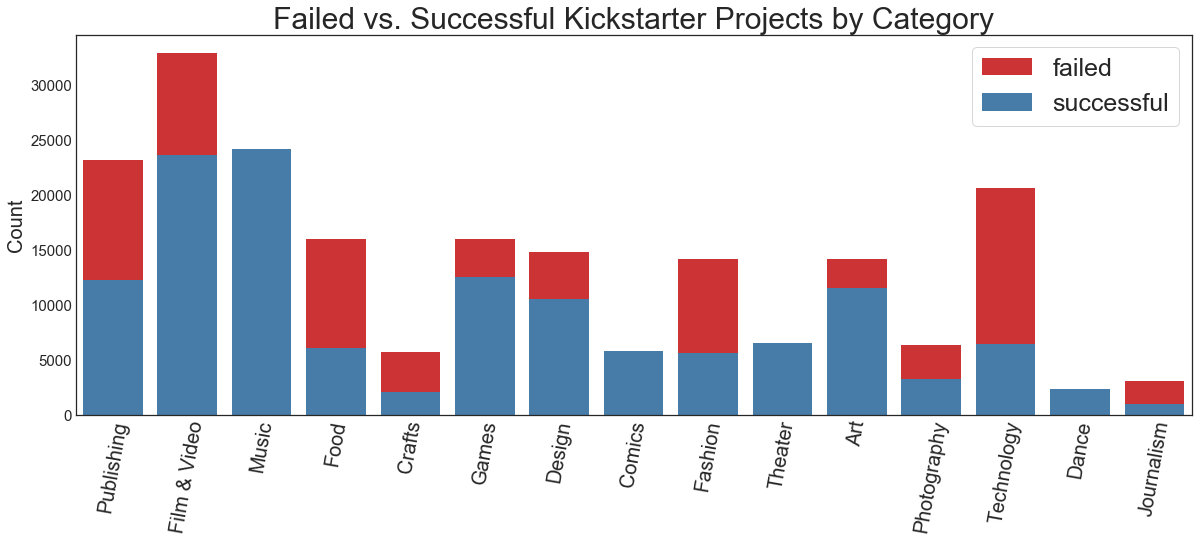

In [56]:
# Number of Failed and Successful Kickstarter Projects by Category
plt.figure(figsize=(20,7))
sns.countplot('main_category', hue='state', dodge=False, data=df, palette='Set1')
plt.legend(loc='best', frameon=True, fontsize=25)
plt.xticks(rotation=80, fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel(' ')
plt.ylabel('Count', fontsize=20)
plt.title('Failed vs. Successful Kickstarter Projects by Category', fontsize=30)

In [57]:
df_category_median = df.groupby('main_category')[['goal', 'pledged', 'backers', 'days']].median().reset_index()
df_category_median


,main_category,goal,pledged,backers,days
0,Art,2963.845,537.00,12,30
1,Comics,3500.000,1735.00,46,30
2,Crafts,2176.060,109.63,4,30
3,Dance,3200.000,2040.00,29,30
4,Design,10000.000,2279.00,34,30
5,Fashion,5500.000,293.89,6,30
6,Film & Video,6400.000,963.84,15,30
7,Food,10000.000,323.00,7,30
8,Games,7500.000,1743.00,40,30
9,Journalism,5000.000,75.00,3,30


Text(0.5,1,'Goal vs. Pledged Median Amount by Category')

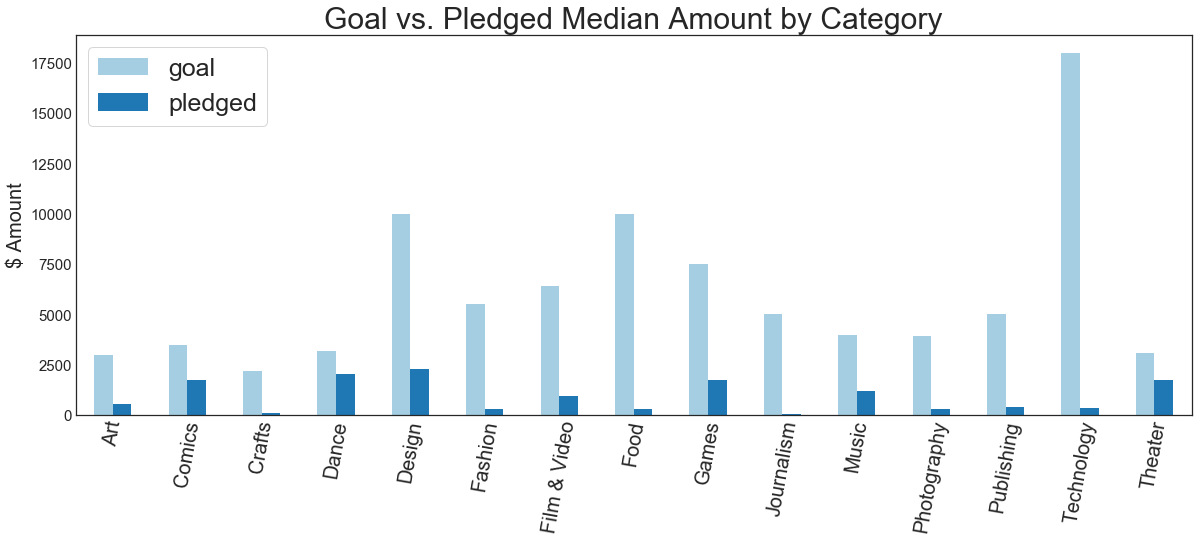

In [58]:
# Goal vs. Pledged Median Amount by Category
df_category_median.plot.bar(x='main_category', y=['goal', 'pledged'], stacked=False, 
                     color=sns.color_palette('Paired'), figsize=(20,7))
plt.legend(loc='best', frameon=True, fontsize=25)
plt.xticks(rotation=80, fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel(' ')
plt.ylabel('$ Amount', fontsize=20)
plt.title('Goal vs. Pledged Median Amount by Category', fontsize=30)

Text(0.5,1,'Median Number of Backers by Category')

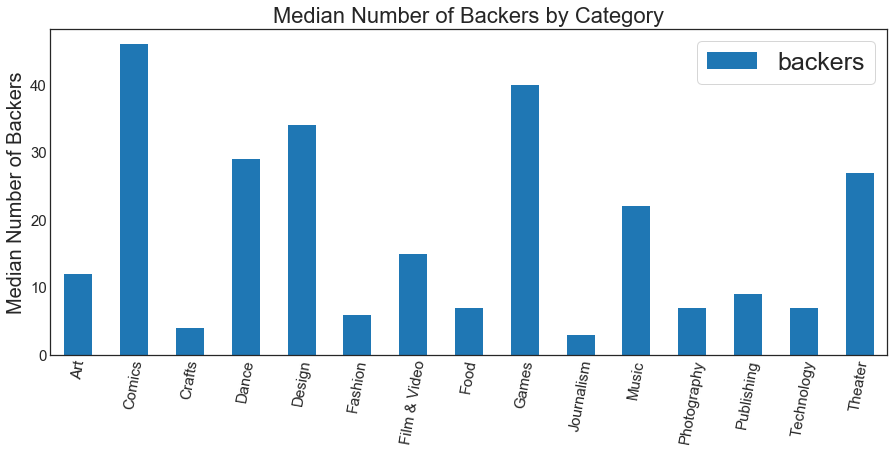

In [59]:
# Median Number of Backers by Category
df_category_median.plot.bar(x='main_category', y='backers', figsize=(15,6))
plt.legend(loc='best', frameon=True, fontsize=25)
plt.xticks(rotation=80, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(' ')
plt.ylabel('Median Number of Backers', fontsize=20)
plt.title('Median Number of Backers by Category', fontsize=22)


----
## Machine Learning

Use Random Forest to do feature selections. Then use Random Forest and logistic regression to predict 
whether a kickstarter project will succeed or fail.


In [60]:
# Change 'successful' to '1' and 'failed' to '0'
# Use Broadcasting
df.loc[df['state']=='successful', 'state'] = 1
df.loc[df['state']=='failed', 'state'] = 0

In [61]:
# Change the 'state' column's data type to integer
df['state'] = df['state'].astype(int)

In [62]:
dfm1 = df.drop(['name', 'main_category', 'launched', 'pledged', 'deadline'], axis=1)

In [63]:
dfm1.isnull().sum()

category    0
currency    0
goal        0
backers     0
state       0
days        0
dtype: int64

In [64]:
corr = dfm1.corr()

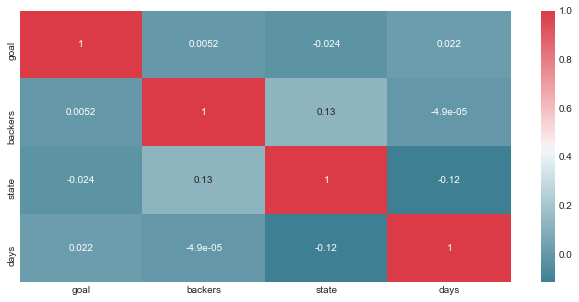

In [65]:
# Make a correlation heatmap

# Set up the matplotlib figure:
f, ax = plt.subplots(figsize=(11, 5))

# Generate a custom diverging colormap:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap, xticklabels=corr.columns, yticklabels=corr.columns)


In [66]:
# In theory, multicollinearity is not a problem for Random Forest.

In [67]:
# Make dummy variables
category_dum = pd.get_dummies(dfm1['category'], drop_first=True)
currency_dum = pd.get_dummies(dfm1['currency'], drop_first=True)

In [68]:
dfm1.drop(['category','currency'], axis=1, inplace=True)

In [69]:
dfm2 = pd.concat([dfm1, category_dum, currency_dum], axis=1)

In [70]:
dfm2.head()

,goal,backers,state,days,Academic,Accessories,Action,Animals,Animation,Anthologies,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,1533.95,0,0,59,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,30000.00,15,0,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,45000.00,3,0,45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5000.00,1,0,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,50000.00,224,1,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [71]:
# Features
X = dfm2.drop('state', axis=1)
X.head()

,goal,backers,days,Academic,Accessories,Action,Animals,Animation,Anthologies,Apparel,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,1533.95,0,59,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,30000.00,15,60,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,45000.00,3,45,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5000.00,1,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,50000.00,224,35,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [72]:
# Target
y = dfm2['state']
y.head()

0    0
1    0
2    0
3    0
5    1
Name: state, dtype: int64

In [73]:
y.value_counts()

0    197716
1    133956
Name: state, dtype: int64

In [74]:
# Make a pipeline
pipe = make_pipeline(RandomForestClassifier(random_state=101)) 
pipe

Pipeline(memory=None,
     steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False))])

In [75]:
# It's very computationally-expensive to do a randomized or full grid search. 
# So I will just fit my data with default model parameters.
# I demonstrated how to do a grid search for optimal parameters in my previous
# capstone project: Global Terrorism. (Also available on my GitHub.)

In [76]:
# Compute predicted y's (y_hat)
predicted = cross_val_predict(pipe, X, y, cv=3, n_jobs=-1)
predicted

array([0, 0, 0, ..., 0, 0, 0])

In [77]:
# Classification table
print(classification_report(y, predicted))

             precision    recall  f1-score   support

          0       0.93      0.94      0.93    197716
          1       0.91      0.90      0.90    133956

avg / total       0.92      0.92      0.92    331672



In [78]:
# Confusion table
print(confusion_matrix(y, predicted))

[[185538  12178]
 [ 13632 120324]]


In [79]:
# Are all the features important for making the prediction?
# Use Random Forest to evaluate the importance of features on the classification task.
names = X.columns
rf = RandomForestClassifier()
rf.fit(X, y)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.68799999999999994, 'backers'), (0.15670000000000001, 'goal'), (0.048899999999999999, 'days'), (0.0074999999999999997, 'Tabletop Games'), (0.0038, 'Apps'), (0.0037000000000000002, 'Theater'), (0.0032000000000000002, 'Video Games'), (0.0032000000000000002, 'Shorts'), (0.0030000000000000001, 'Web'), (0.0028999999999999998, 'USD'), (0.0025000000000000001, 'Product Design'), (0.0023, 'Indie Rock'), (0.0020999999999999999, 'Country & Folk'), (0.0019, 'GBP'), (0.0016999999999999999, 'Apparel'), (0.0016000000000000001, 'EUR'), (0.0015, 'Music'), (0.0015, 'Documentary'), (0.0015, 'Dance'), (0.0014, 'Food'), (0.0014, 'Fiction'), (0.0012999999999999999, 'Rock'), (0.0012999999999999999, 'Classical Music'), (0.0012999999999999999, 'CAD'), (0.0011999999999999999, 'Technology'), (0.0011999999999999999, 'Film & Video'), (0.0011999999999999999, 'Fashion'), (0.0011999999999999999, 'Comics'), (0.0011999999999999999, 'Art'), (0.0011000000000000001, 'Nonfiction'), (0.001

In [80]:
# Use only the first three most important features from the feature selection
 
dfm3 = dfm2[['backers', 'goal', 'days', 'state']]
dfm3.head()

,backers,goal,days,state
0,0,1533.95,59,0
1,15,30000.00,60,0
2,3,45000.00,45,0
3,1,5000.00,30,0
5,224,50000.00,35,1


In [81]:
# Features
X_3 = dfm3.drop('state', axis=1)
X_3.head()

,backers,goal,days
0,0,1533.95,59
1,15,30000.00,60
2,3,45000.00,45
3,1,5000.00,30
5,224,50000.00,35


In [82]:
# Target
y_3 = dfm3['state']
y_3.head()

0    0
1    0
2    0
3    0
5    1
Name: state, dtype: int64

In [83]:
# Make a pipeline
pipe_3 = make_pipeline(RandomForestClassifier(random_state=101)) 
pipe_3

Pipeline(memory=None,
     steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False))])

In [84]:
# Compute predicted y's (y_hat)
predicted_3 = cross_val_predict(pipe_3, X_3, y_3, cv=3, n_jobs=-1)
predicted_3

array([0, 0, 0, ..., 0, 0, 1])

In [85]:
# Classification table
print(classification_report(y_3, predicted_3))

             precision    recall  f1-score   support

          0       0.93      0.93      0.93    197716
          1       0.89      0.89      0.89    133956

avg / total       0.91      0.91      0.91    331672



In [86]:
# Confusion table
print(confusion_matrix(y_3, predicted_3))

[[182975  14741]
 [ 14287 119669]]


Now, let's try another algorithm: logistic regression and see how it performs.

In [87]:
# Make a logistic regression pipeline
pipe_4 = make_pipeline(LogisticRegression(random_state=101)) 
pipe_4

Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=101, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [88]:
## Compute predicted y's (y_hat)
# predicted_4 = cross_val_predict(pipe_4, X, y, n_jobs=-1)
# predicted_4

In [89]:
# Too computationally expensive to compute predictions with the cross-validation method.
# So, I changed to a train-test split method to compute the predictions.
X_train, X_test, y_train, y_test = train_test_split(X_3, y_3, test_size=0.3, random_state=101)

In [90]:
pipe_4.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=101, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [91]:
predicted_4 = pipe_4.predict(X_test)

In [92]:
# classification table:
print(classification_report(y_test, predicted_4))

             precision    recall  f1-score   support

          0       0.89      0.96      0.92     59400
          1       0.93      0.83      0.88     40102

avg / total       0.91      0.91      0.91     99502



In [93]:
# Confusion table
print(confusion_matrix(y_test, predicted_4))

[[56765  2635]
 [ 6703 33399]]


----
## Text Classification using NLP  

The original dataset has a text-based column called 'name'.

Can I predict if a Kickstarter project will succeed or fail solely based on this 'name' column?

I will use NLP to convert text-based data into a numeric matrix, then use Naive Bayes classification
and Random Forest classification to do the predictions.

In [94]:
df.columns

Index(['name', 'category', 'main_category', 'launched', 'deadline', 'currency',
       'goal', 'pledged', 'backers', 'state', 'days'],
      dtype='object')

In [95]:
df.state.value_counts()

0    197716
1    133956
Name: state, dtype: int64

In [96]:
dfn = df[['name', 'state']]
dfn.head()

,name,state
0,The Songs of Adelaide & Abullah,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,0
2,Where is Hank?,0
3,ToshiCapital Rekordz Needs Help to Complete Album,0
5,Monarch Espresso Bar,1


In [97]:
dfn.groupby('state')[['name']].describe()

name                                       
        count  unique                       top freq
state                                               
0      197716  196761  New EP/Music Development   14
1      133956  133562               Debut Album    5

In [98]:
# Make a new column to detect how long the names are:
dfn['length'] = dfn['name'].apply(len)
dfn.head()

,name,state,length
0,The Songs of Adelaide & Abullah,0,31
1,Greeting From Earth: ZGAC Arts Capsule For ET,0,45
2,Where is Hank?,0,14
3,ToshiCapital Rekordz Needs Help to Complete Album,0,49
5,Monarch Espresso Bar,1,20


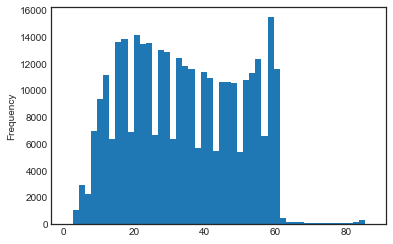

In [99]:
dfn['length'].plot(bins=50, kind='hist') 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a24b6e198>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a5838e080>], dtype=object)

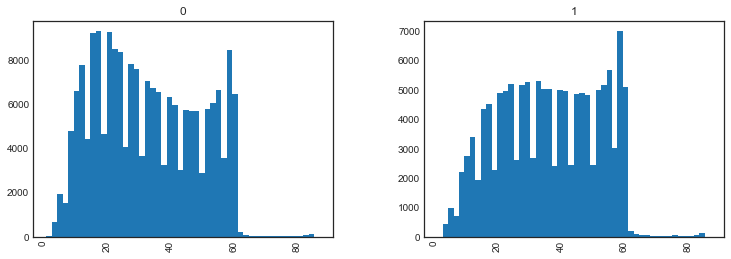

In [100]:
dfn.hist(column='length', by='state', bins=50, figsize=(12,4))

In [101]:
dfn.head()

,name,state,length
0,The Songs of Adelaide & Abullah,0,31
1,Greeting From Earth: ZGAC Arts Capsule For ET,0,45
2,Where is Hank?,0,14
3,ToshiCapital Rekordz Needs Help to Complete Album,0,49
5,Monarch Espresso Bar,1,20


In [102]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 3 columns):
name      331672 non-null object
state     331672 non-null int64
length    331672 non-null int64
dtypes: int64(2), object(1)
memory usage: 20.1+ MB


In [103]:
# Make a function to visualize the words in 'successful' and 'failed' projects.
def visualize(num):
  words = ''
  for msg in dfn[dfn['state'] == num]['name']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=1000, height=600).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

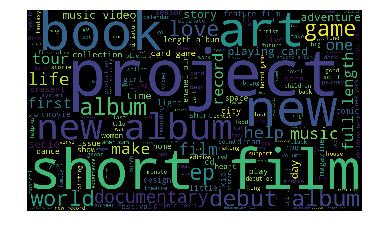

In [104]:
# A word cloud for successful projects
visualize(1)

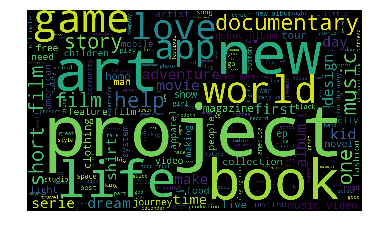

In [105]:
# A word cloud for failed projects
visualize(0)

----
Predict whether a project will succeed or fail when the project gets listed:

In [106]:
X_n1 = dfn['name']

In [107]:
# target:
y_n1 = dfn['state']

In [108]:
y_n1.value_counts()

0    197716
1    133956
Name: state, dtype: int64

In [109]:
# Use Naive Bayes classification
pipe3 = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())  
pipe3

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [110]:
predicted3 = cross_val_predict(pipe3, X_n1, y_n1, cv=3, n_jobs=-1)

In [111]:
# Classification table:
print(classification_report(y_n1, predicted3))

             precision    recall  f1-score   support

          0       0.65      0.88      0.75    197716
          1       0.63      0.29      0.40    133956

avg / total       0.64      0.64      0.61    331672



In [112]:
# Use Random Forest classification
pipe4 = make_pipeline(TfidfVectorizer(stop_words='english'), RandomForestClassifier())  
pipe4

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [113]:
# Too computationally expensive to compute predictions with the cross-validation method.
# predicted4 = cross_val_predict(pipe4, X_n1, y_n1, cv=3, n_jobs=-1)

In [114]:
# So, I changed to a train-test split method to compute the predictions.
X_train, X_test, y_train, y_test = train_test_split(X_n1, y_n1, test_size=0.3, random_state=101)

In [115]:
pipe4.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [116]:
predicted4 = pipe4.predict(X_test)

In [117]:
# classification table:
print(classification_report(y_test, predicted4))

             precision    recall  f1-score   support

          0       0.66      0.81      0.72     59400
          1       0.56      0.37      0.45     40102

avg / total       0.62      0.63      0.61     99502



In [118]:
# As expected, predicting whether a Kickstarter project will succeed or fail solely based on 
# the 'name' column does not have as good a prediction power compared to what we've done eariler 
# with other columns.

----
## Recommendations for Investing in a New Project

My client is interested in investing in some kickstarter projects in the Film & video category. 
He wants some recommendations on which project he should invest in.

In [119]:
dfr = pd.read_csv('ks-projects-201801.csv', encoding="ISO-8859-1")

In [120]:
# Subset the df with all the columns I want.
dfr = dfr[['name', 'category', 'main_category',  
         'usd_goal_real', 'usd_pledged_real', 
         'backers', 'state']]

In [121]:
# Subset the data frame to 'Film & Video' only
dfr = dfr[dfr.main_category=='Film & Video']

In [122]:
# Drop duplicate data
dfr = dfr.drop_duplicates()

In [123]:
# Drop NaN values
dfr.dropna(inplace=True)

In [124]:
dfr.rename(columns={'usd_goal_real':'goal', 'usd_pledged_real':'pledged'}, inplace=True) 

In [125]:
# Add a column 'surplus'
dfr['surplus'] =  dfr['pledged'] - dfr['goal'] 
dfr['surplus'].head()

1    -27579.00
2    -44780.00
4    -18217.00
9    -58759.43
27    26860.99
Name: surplus, dtype: float64

In [126]:
# Subset the data frame to 'live' projects only (projects that people can still invest in)
dfr_live = dfr[dfr.state=='live']
dfr_live.head()

,name,category,main_category,goal,pledged,backers,state,surplus
183,KILOS.,Thrillers,Film & Video,5000.00,310.00,4,live,-4690.00
458,The Man in the Field,Horror,Film & Video,1159.38,563.32,11,live,-596.06
537,Dear Atlantas,Film & Video,Film & Video,2000.00,5.00,1,live,-1995.00
752,Durango Falls TV Show,Film & Video,Film & Video,10000.00,1.00,1,live,-9999.00
1920,MORE BIKE LIFE,Documentary,Film & Video,18372.07,0.00,0,live,-18372.07


In [127]:
# Sort 'live' projects by 'surplus' and 'backers'
dfr_sort = dfr_live.sort_values(by=['surplus', 'backers'], axis=0, ascending=False, na_position='first') 
dfr_sort.head(20)

,name,category,main_category,goal,pledged,backers,state,surplus
319442,MADE YOU LOOK,Shorts,Film & Video,3500.00,6204.00,81,live,2704.00
242907,The Whibbits! A stop motion animated web serie...,Animation,Film & Video,818.39,2482.44,30,live,1664.05
190837,LaVoy: Dead Man Talking,Documentary,Film & Video,12000.00,13450.00,125,live,1450.00
341218,CADABRA - A Short Film,Comedy,Film & Video,406.55,1599.09,7,live,1192.54
127730,The Walk,Film & Video,Film & Video,6775.80,7479.13,73,live,703.33
132682,"""BRIDGES"" a short doc about the in-betweeners",Documentary,Film & Video,7000.00,7656.00,56,live,656.00
314947,Lady (short film),Shorts,Film & Video,1295.78,1853.65,36,live,557.87
127532,Code Switch,Horror,Film & Video,3000.00,3511.00,27,live,511.00
246730,FATHOM | an Eco-Thriller,Shorts,Film & Video,6000.00,6452.00,35,live,452.00
43336,BEAT IT,Shorts,Film & Video,1355.16,1775.26,20,live,420.10


In [128]:
# Obviously, my client should invest in projects that are already successful, i.e. live projects 
# that the pledged amount >= goal amount